In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:

# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
classes = Base.classes.keys()
print(classes)

['measurement', 'station']


In [7]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement


In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)
stations = session.query(station).all()
measurements = session.query(measurement).all()


In [9]:
#List column names for the two tables
inspector = inspect(engine)
station_columns = inspector.get_columns('station')
print("Station:")
for column in station_columns:
    print (f"{column['name']} {column['type']}")
print("________________________________________")
print(" ")
measurement_columns = inspector.get_columns('measurement')
print("Measurement:")
for column in measurement_columns:
    print (f"{column['name']} {column['type']}")


Station:
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT
________________________________________
 
Measurement:
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.

#orderby descending and select first
last_date = session.query(measurement.date
                           ).order_by(measurement.date.desc()).first()[0]
print(last_date)

2017-08-23


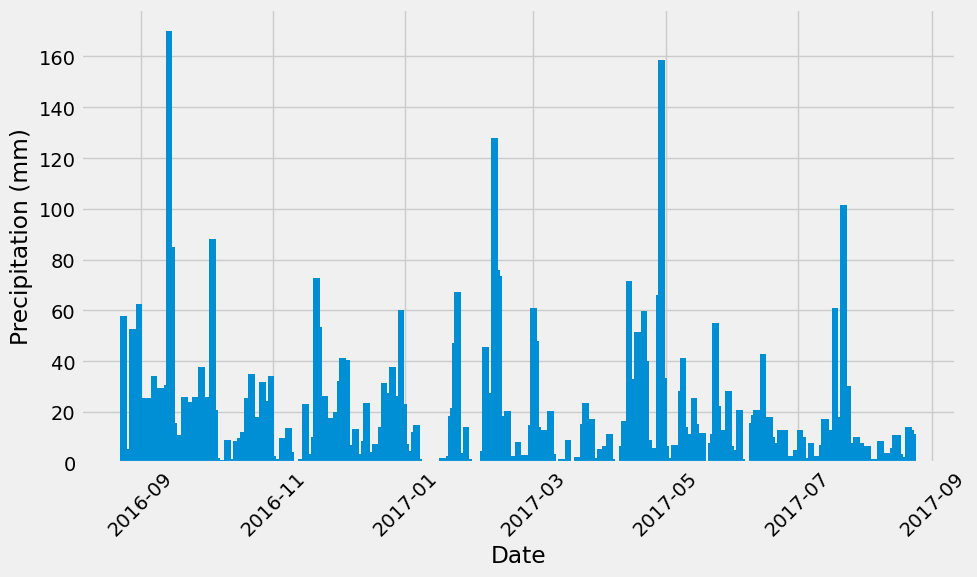

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
#.strftime to format the date properly
last_year = dt.datetime.strptime(last_date, '%Y-%m-%d') - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
query_result = session.query(measurement.date, measurement.prcp).filter(measurement.date >= last_year).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(query_result, columns=['Date', 'Precipitation'])
df['Date'] = pd.to_datetime(df['Date'])

# Sort the dataframe by date
df.sort_values('Date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.bar(df['Date'], df['Precipitation'], width=3, label="Precipitation")
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
summarystat = df.describe()

print(summarystat)

       Precipitation
count    2021.000000
mean        4.505888
std        11.713487
min         0.000000
25%         0.000000
50%         0.500000
75%         3.300000
max       170.200000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(station).count()

print(f"Total number of stations: {total_stations}")

Total number of stations: 9


In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()


for station, count in active_stations:
    print(f"(Station: '{station}', Count: {count})")

(Station: 'USC00519281', Count: 2772)
(Station: 'USC00519397', Count: 2724)
(Station: 'USC00513117', Count: 2709)
(Station: 'USC00519523', Count: 2669)
(Station: 'USC00516128', Count: 2612)
(Station: 'USC00514830', Count: 2202)
(Station: 'USC00511918', Count: 1979)
(Station: 'USC00517948', Count: 1372)
(Station: 'USC00518838', Count: 511)


In [14]:
# Using the most active station id from the previous query, 
#calculate the lowest, highest, and average temperature.

most_active_station = active_stations[0][0]  # Get the station id of the most active station
temperature_stats = session.query(func.min(measurement.tobs),
                                  func.max(measurement.tobs),
                                  func.avg(measurement.tobs)).\
    filter(measurement.station == most_active_station).all()

# Print the result
print(f"(min:{temperature_stats[0][0]}, max:{temperature_stats[0][1]}, avg:{temperature_stats[0][2]})")

(min:12.2, max:29.4, avg:22.03582251082252)


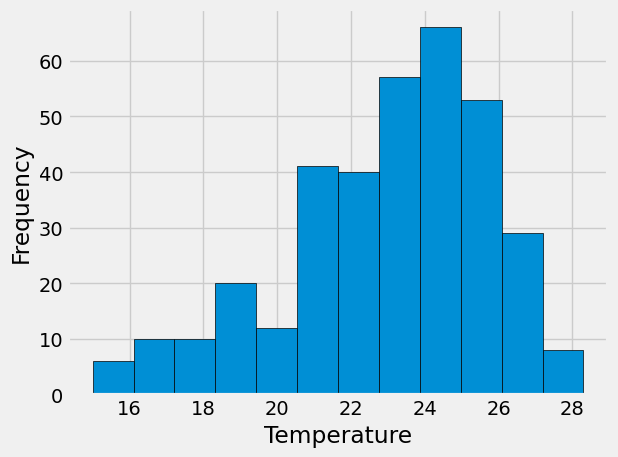

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data 
#for this station and plot the results as a histogram
temperature_data = session.query(measurement.tobs).\
    filter(measurement.station == most_active_station).\
    filter(measurement.date >= one_year_ago).all()

# Convert the query results to a list
temperatures = [temp[0] for temp in temperature_data]

# Plot the histogram
plt.hist(temperatures, bins=12, edgecolor='black',label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Close Session

In [15]:
# Close Session
session.close()